In [1]:
#производим импорт необходимых библиотек здесь
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import lightgbm as lgb

#визуализация
import matplotlib.pyplot as plt
import seaborn as sns

#для адекватного отображения Pipeline
import sklearn
sklearn.set_config(transform_output="pandas")

from sklearn.model_selection import train_test_split, KFold, cross_val_score

#Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

#models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor


#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error, accuracy_score

import optuna
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

In [2]:
#загрузим датасеты
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [3]:
train_df.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [4]:
#немного сбора инфы про датасет
train_df.dtypes
train_df.isna().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
X, y = train_df.drop('SalePrice', axis=1), train_df['SalePrice']

# добавим по одной строке в тест и трейн с NaN, где у обоих они присутствуют (крест на крест)
train_na = X.columns[X.isna().any()]
test_na = test_df.columns[test_df.isna().any()]
#создаем искусственную строку
new_row = {}

for col in X.columns:
    if col in train_na:
        new_row[col] = np.nan
    elif col in test_na and col not in train_na:
        new_row[col] = np.nan
    else:
        if X[col].dtype == 'object':
            new_row[col] = X[col].mode()[0]
        else:
            new_row[col] = X[col].mean()

X = pd.concat([X, pd.DataFrame([new_row])], ignore_index=True)
test_df = pd.concat([test_df, pd.DataFrame([new_row])], ignore_index=True)

In [6]:
y = pd.concat([y, pd.Series([y.mean()])], ignore_index=True)

In [7]:
len(y), len(X)

(1461, 1461)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
train_nan = train_df.columns[train_df.isna().any()]
test_nan = test_df.columns[test_df.isna().any()]
nan_cols = train_nan.union(test_nan)

In [10]:
#разделим категориальные признаки от числовых, добавим список с пропущенными значениями
num_features = train_df.select_dtypes(exclude='object')
cat_features = train_df.select_dtypes(include='object')

nan_dict = {'cat':[col for col in cat_features if col in nan_cols], 'num':[col for col in num_features if col in nan_cols]}

<Axes: >

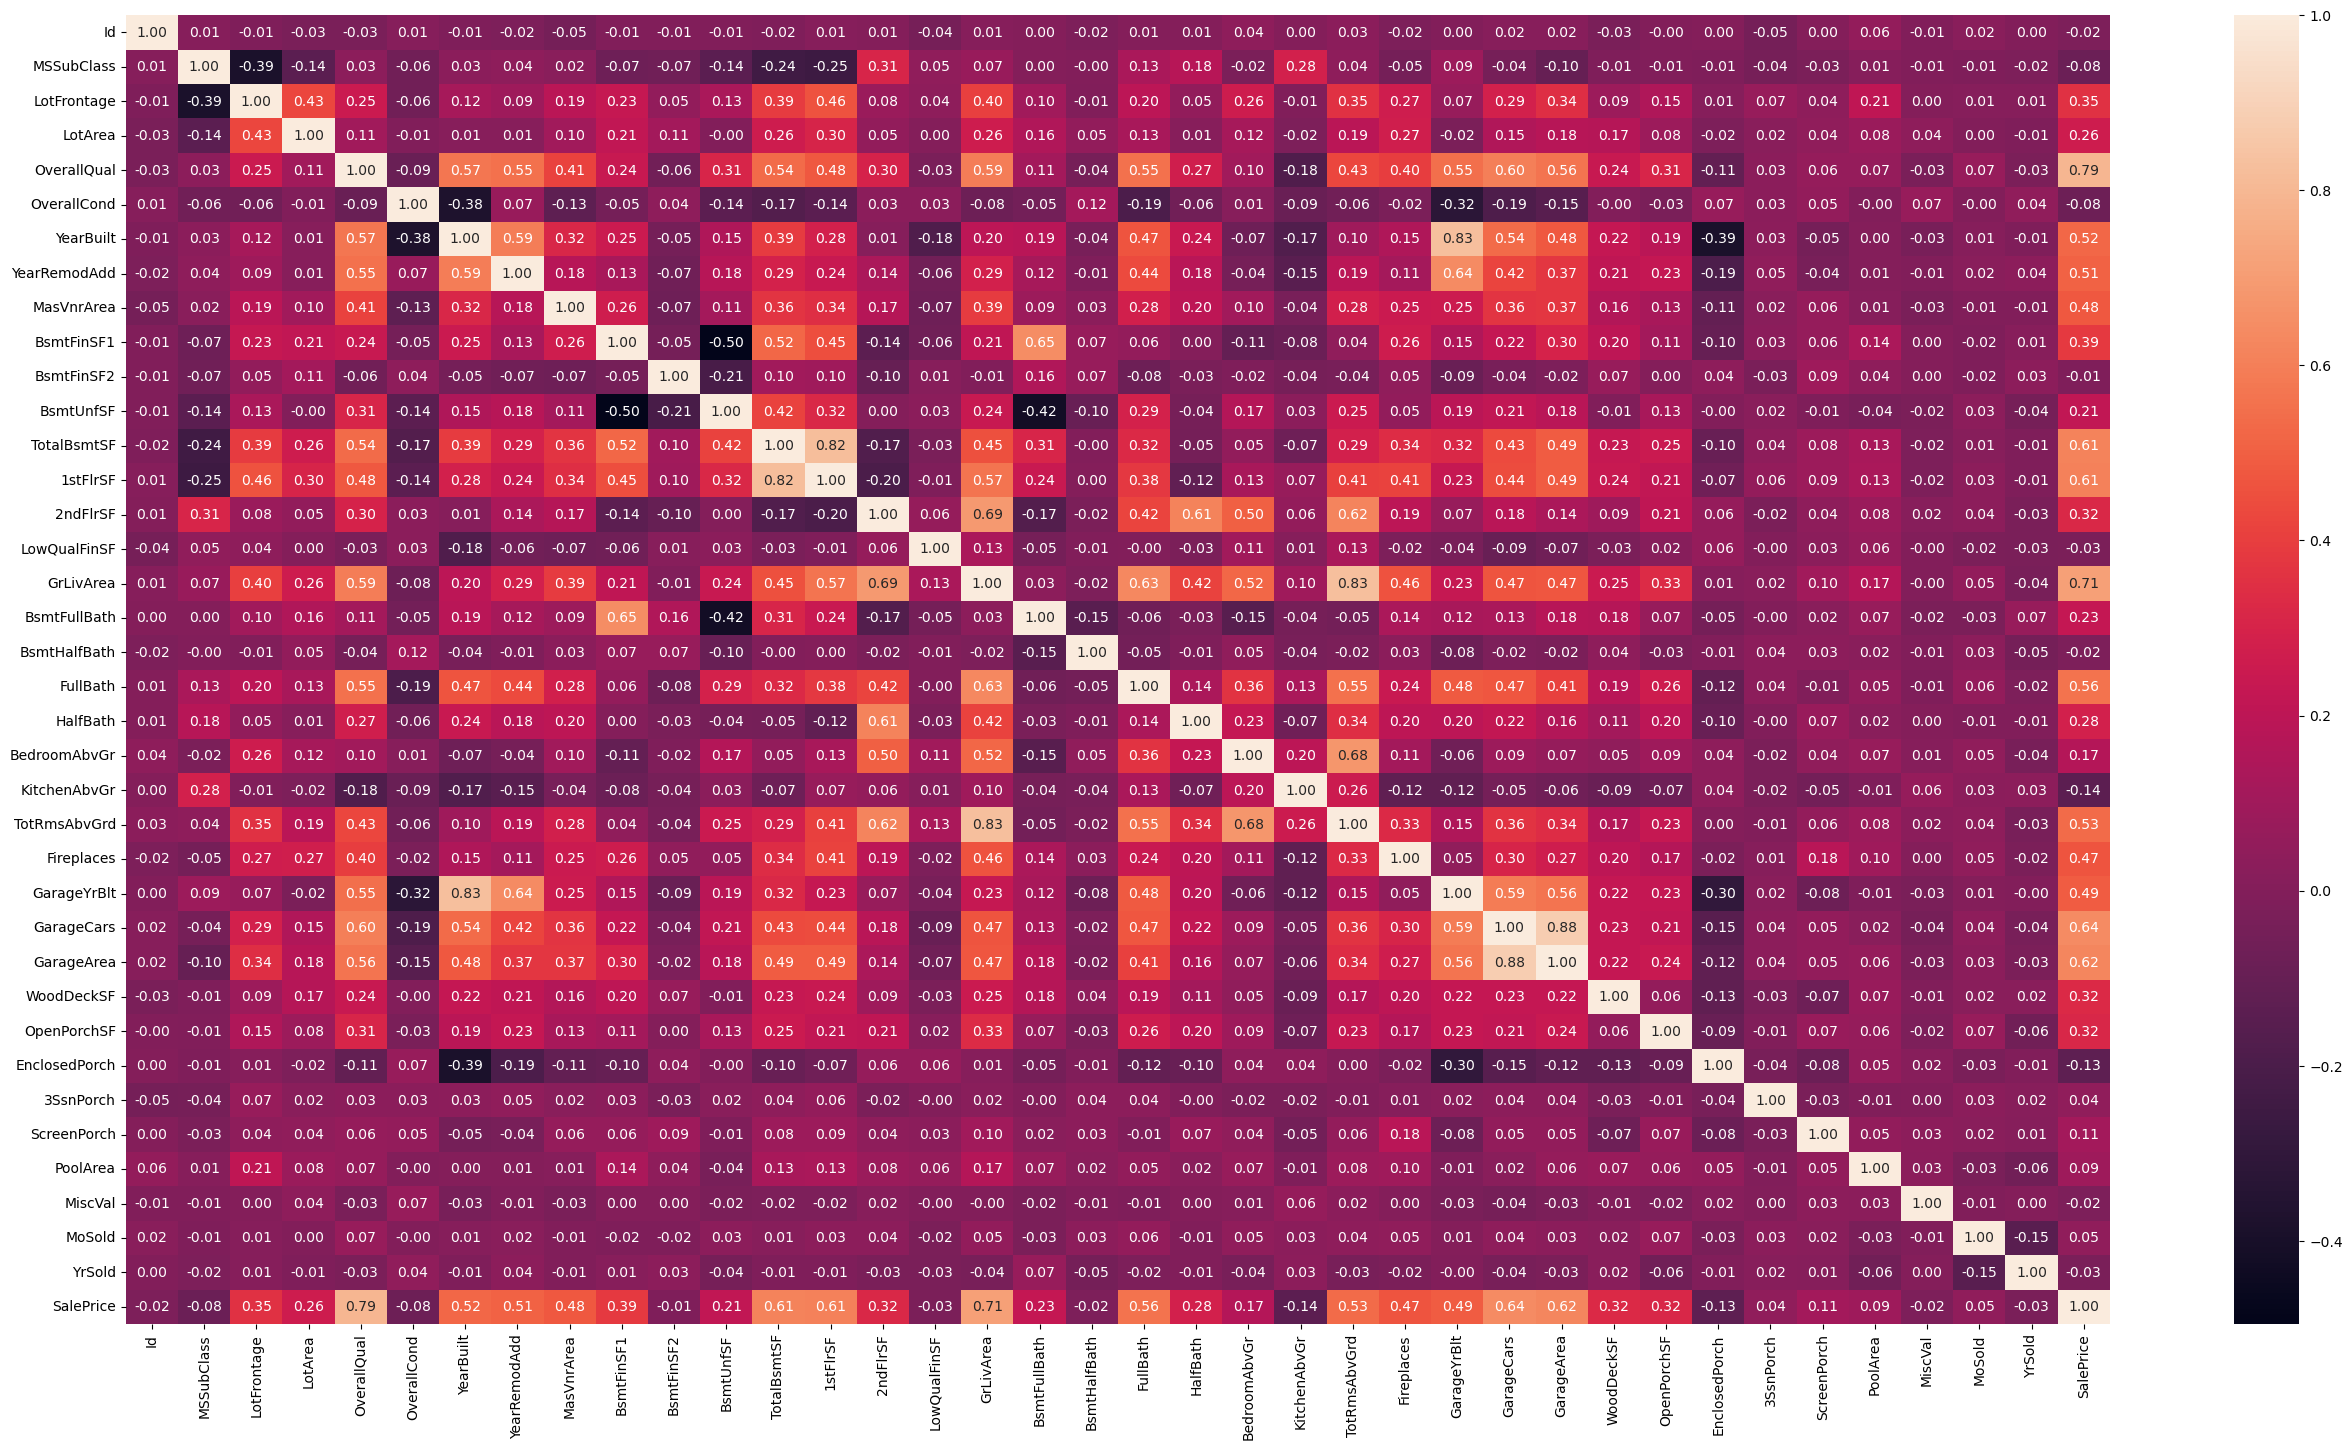

In [11]:
#построим матрицу корреляции
num_df = train_df[train_df.select_dtypes(include=['int', 'float']).columns.tolist()]
plt.rcParams['figure.figsize'] = [32,17]
sns.heatmap(num_df.corr(), annot=True, fmt='.2f')

In [12]:
# Выкинуть - Id, YrSold, MoSold, MiscVal, SaleType?

#YearBuilt + GarageYrBlt - надо даты в года перевести? плюс заменить на один год (дом+гараж)
#YearRemodAdd - тоже убрать даты
#TotRmsAbvGrd + GrLivArea - это площадь комнат над уровнем земли + колво комнат, сделать в одну фичу?
#TotalBsmtSF + 1stFlrSF - площадь первого этада + площадь подвала - очень связаны, сделать одну фичу?
#GarageCars, GarageArea - зависят друг от друга, показывают размер гаража, сделать одной фичей?

# MasVnrType - есть тип None, это типа отсутствует? - да, сделать 0
# 'Alley',  - заполнить 
# 'MasVnrType', - сделать 0 вместо NaN
# 'BsmtQual', - сделать 0 подвал
# 'BsmtCond', - сделать 0 подвал
# 'BsmtExposure', - сделать 0 подвал
# 'BsmtFinType1', - сделать 0 подвал
# 'BsmtFinType2', - сделать 0 подвал
# 'Electrical', - вряд ли есть без отопления, заполнить самым частым
# 'FireplaceQu', - сделать 0 камин 
# 'GarageType', - нет гаража, сделать 0
# 'GarageFinish', - нет гаража, делаем 0
# 'GarageQual', - нет гаража, 0
# 'GarageCond', - нет гаража, 0
# 'PoolQC', - нет бассейна, делаем 0
# 'Fence', - нет забора, делаем 0
# 'MiscFeature' - нет никаких фич, делаем 0

# 'LotFrontage', - нет футов улицы, делаем 0
# 'MasVnrArea', - нет облицовки, делай 0
# 'GarageYrBlt'- нет гаража, 0. предлагаю везде где есть года сделать общее количество лет на текущее время (вместо года)

In [13]:
#начнем построениe структуры Pipeline
# for key in nan_dict:
#     nan_dict[key] = [x for x in nan_dict[key] if x not in drop_features]

#заполним пропуски
my_imputer = ColumnTransformer(
    transformers = [
        ('num_imputer', SimpleImputer(strategy='constant', fill_value=0), nan_dict['num']),
        ('cat_imputer_zeros', SimpleImputer(strategy='constant', fill_value='zero'), nan_dict['cat']),
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)

In [14]:
# заполним в данных отсутствующие значения. выделим категориальные признаки повторно
processed_data = my_imputer.fit_transform(train_df)
proc_df = pd.DataFrame(processed_data, columns=X_train.columns)
cat_proc = proc_df.select_dtypes(include='object')

In [15]:
# разберемся теперь с категориальными признаками
# сделаем тест хи-квадрат для оценки независимости между признаком и таргетом. Низкое p - есть связь
p_values = []
for cat in cat_proc.columns:
    cont_table = pd.crosstab(train_df[cat], train_df['SalePrice'])
    if (cont_table.values < 5).any():
        chi2, p, dof, ex = chi2_contingency(cont_table, correction=True)
    else:
        chi2, p, dof, ex = chi2_contingency(cont_table)
    p_values.append(p)
results = pd.DataFrame({'feature':cat_proc.columns, 'p_value':p_values})
results = results.sort_values(by='p_value')
# results.to_csv(r"cat_features_p_value.csv", index=False, sep=";")

#отбросим те, у которых p_value слишком большой
dropping = results.loc[results['p_value'] > 0.001, 'feature'].reset_index()

In [16]:
# строим дальше. 
drop_features = ['Id', 'YrSold', 'MoSold', 'MiscVal', 'SaleType', 'GarageYrBlt', 'TotRmsAbvGrd', '1stFlrSF', 'GarageCars']
drop_features += dropping['feature'].tolist()

#выкинем ненужные столбцы
my_dropper = ColumnTransformer(
    transformers = [
        ('drop_features', 'drop', drop_features)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough' 
)


In [17]:
fitted_data = my_dropper.fit_transform(proc_df)
fitted_df = pd.DataFrame(fitted_data)
fitted_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,Neighborhood,OverallQual,OverallCond,YearBuilt,...,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,CollgCr,7,5,2003,...,RFn,548.0,TA,0,61,0,0,0,0,Normal
1,20,RL,80.0,9600,Pave,Reg,Veenker,6,8,1976,...,RFn,460.0,TA,298,0,0,0,0,0,Normal
2,60,RL,68.0,11250,Pave,IR1,CollgCr,7,5,2001,...,RFn,608.0,TA,0,42,0,0,0,0,Normal
3,70,RL,60.0,9550,Pave,IR1,Crawfor,7,5,1915,...,Unf,642.0,TA,0,35,272,0,0,0,Abnorml
4,60,RL,84.0,14260,Pave,IR1,NoRidge,8,5,2000,...,RFn,836.0,TA,192,84,0,0,0,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,RL,62.0,7917,Pave,Reg,Gilbert,6,5,1999,...,RFn,460.0,TA,0,40,0,0,0,0,Normal
1456,20,RL,85.0,13175,Pave,Reg,NWAmes,6,6,1978,...,Unf,500.0,TA,349,0,0,0,0,0,Normal
1457,70,RL,66.0,9042,Pave,Reg,Crawfor,7,9,1941,...,RFn,252.0,TA,0,60,0,0,0,0,Normal
1458,20,RL,68.0,9717,Pave,Reg,NAmes,5,6,1950,...,Unf,240.0,TA,366,0,112,0,0,0,Normal


In [18]:
# кодирование и нормировка данных
num_encode_col = fitted_df.select_dtypes(exclude='object').columns.tolist()
ordinal_encode_col = fitted_df.select_dtypes(include='object').columns.tolist()

my_encoder = ColumnTransformer(
    transformers = [
        ('ordinal_encoding', OrdinalEncoder(), ordinal_encode_col),
        ('scaling num features', StandardScaler(), num_encode_col)
    ],
    verbose_feature_names_out = False,
    remainder = 'passthrough'
)
encoded = my_encoder.fit_transform(fitted_df)

In [19]:
# собираем preprocessor
preprocessor = Pipeline(
    [
        ('imputer', my_imputer),
        ('drop features', my_dropper),
        ('encode and scale', my_encoder)
    ]
)
preprocessed = preprocessor.fit_transform(X_train)
preprocessed.to_csv(r"preprocessed.csv", index=False, sep=";")

<Axes: >

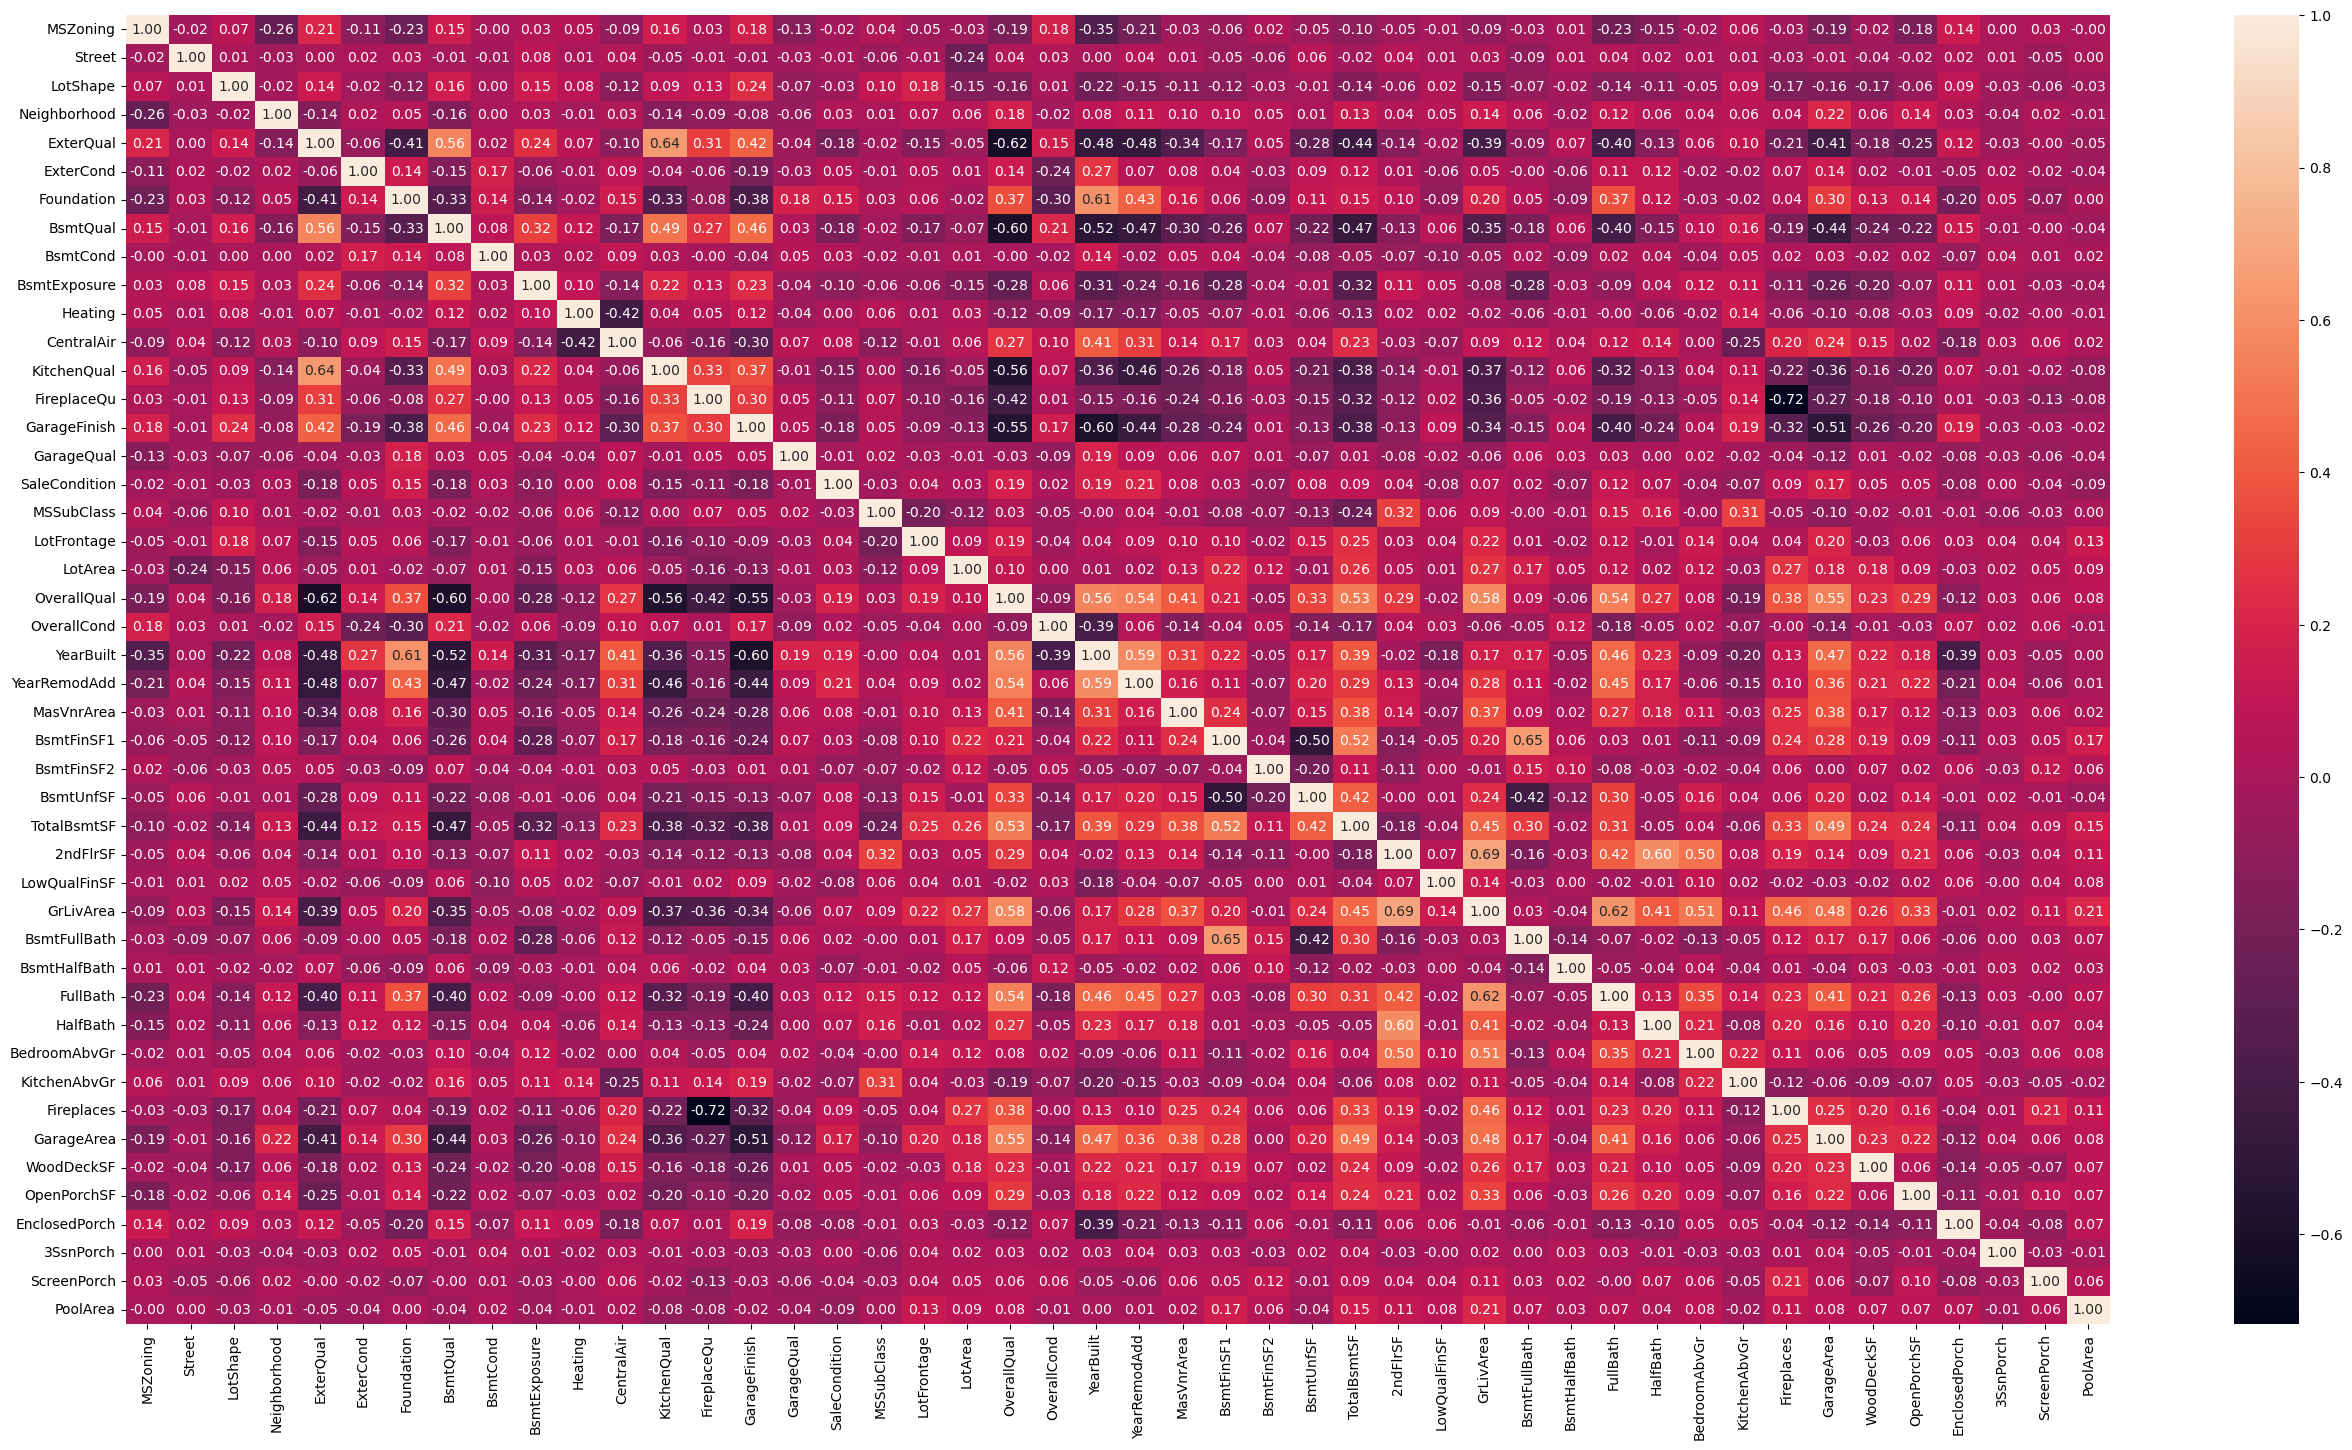

In [20]:
plt.rcParams['figure.figsize'] = [32,17]
sns.heatmap(preprocessed.corr(), annot=True, fmt='.2f')

In [21]:
preprocessor.transform(X_valid)

,MSZoning,Street,LotShape,Neighborhood,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,...,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
892,3.0,1.0,3.0,19.0,3.0,4.0,1.0,3.0,3.0,3.0,...,0.136361,-0.212938,-0.959784,-1.002956,0.742455,-0.715083,-0.352243,-0.121101,-0.276078,-0.07105
1105,3.0,1.0,0.0,15.0,2.0,4.0,2.0,0.0,3.0,0.0,...,0.136361,-0.212938,2.142921,1.116276,0.696141,-0.253913,-0.352243,-0.121101,-0.276078,-0.07105
413,4.0,1.0,3.0,17.0,3.0,4.0,1.0,3.0,3.0,3.0,...,-1.106640,-0.212938,0.591569,-0.548835,-0.739576,-0.715083,1.742729,-0.121101,-0.276078,-0.07105
522,4.0,1.0,3.0,3.0,3.0,2.0,1.0,3.0,3.0,3.0,...,0.136361,-0.212938,2.142921,-0.265009,-0.739576,-0.369206,0.227903,-0.121101,-0.276078,-0.07105
1036,3.0,1.0,0.0,23.0,2.0,4.0,2.0,0.0,3.0,1.0,...,-1.106640,-0.212938,0.591569,2.062362,1.020335,-0.715083,-0.352243,-0.121101,-0.276078,-0.07105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1361,3.0,1.0,0.0,22.0,2.0,4.0,2.0,0.0,3.0,0.0,...,0.136361,-0.212938,0.591569,-0.217705,0.557201,-0.196267,-0.352243,-0.121101,-0.276078,-0.07105
802,3.0,1.0,3.0,5.0,2.0,4.0,2.0,2.0,3.0,0.0,...,0.136361,-0.212938,0.591569,-0.312314,-0.461696,-0.455675,-0.352243,-0.121101,-0.276078,-0.07105
651,3.0,1.0,3.0,7.0,3.0,4.0,1.0,3.0,3.0,2.0,...,1.379363,-0.212938,0.591569,-0.851583,0.186693,-0.715083,-0.352243,-0.121101,-0.276078,-0.07105
722,3.0,1.0,3.0,12.0,3.0,2.0,1.0,3.0,3.0,3.0,...,0.136361,-0.212938,-0.959784,-0.061601,-0.739576,-0.715083,-0.352243,-0.121101,-0.276078,-0.07105


### Обучаем ML-модели. Получаем основные метрики. Собираем по ним результаты в таблицу.

In [22]:
#LinearRegression

lr_ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', LinearRegression())
    ]
)

In [23]:
lr_ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    '2ndFlrSF',
                                                                    'LowQualFinSF',
                                                                    'GrLivArea',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'FullBath',
                                                                    'HalfBath',
                                                                    'BedroomAbvGr',
                                                                    'KitchenAbvGr',
                                                                    'Fireplaces',
                                                                    'GarageArea',
                                                                    'WoodDeckSF',
                                                                    'OpenPorchSF',
                                                                    'EnclosedPorch',
                                                                    '3SsnPorch',
                                                                    'ScreenPorch',
                                                                    'PoolArea'])],
                                                    verbose_feature_names_out=False))])),
                ('model', LinearRegression())])

In [24]:
y_pred_lr = lr_ml_pipeline.predict(X_valid)

In [25]:
# считаем метрики для LinearRegression

mae_lr = mean_absolute_error(y_valid, y_pred_lr)
mse_lr = mean_squared_error(y_valid, y_pred_lr)
r2_lr = r2_score(y_valid, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
rmlse_lr = np.sqrt(np.mean(np.log(y_valid) - np.log(y_pred_lr)) ** 2)

# Запишем в переменную

lr = [mae_lr, mse_lr, r2_lr, rmse_lr, rmlse_lr]

In [26]:
print(f'{y_train.min()} - минимум, {y_train.max()} - максимум, {y_train.mean()} - среднее')

34900.0 - минимум, 745000.0 - максимум, 181472.29640059112 - среднее


In [27]:
rmlse_lr

0.005117112986396623

In [28]:
#RandomForest

rf_ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ]
)

In [29]:
rf_ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    '2ndFlrSF',
                                                                    'LowQualFinSF',
                                                                    'GrLivArea',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'FullBath',
                                                                    'HalfBath',
                                                                    'BedroomAbvGr',
                                                                    'KitchenAbvGr',
                                                                    'Fireplaces',
                                                                    'GarageArea',
                                                                    'WoodDeckSF',
                                                                    'OpenPorchSF',
                                                                    'EnclosedPorch',
                                                                    '3SsnPorch',
                                                                    'ScreenPorch',
                                                                    'PoolArea'])],
                                                    verbose_feature_names_out=False))])),
                ('model', RandomForestRegressor(random_state=42))])

In [30]:
y_pred_rf = rf_ml_pipeline.predict(X_valid)

In [31]:
# считаем метрики

mae_rf = mean_absolute_error(y_valid, y_pred_rf)
mse_rf = mean_squared_error(y_valid, y_pred_rf)
r2_rf = r2_score(y_valid, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
rmlse_rf = np.sqrt(np.mean(np.log(y_valid) - np.log(y_pred_rf)) ** 2)

# записываем в переменную

rf = [mae_rf, mse_rf, r2_rf, rmse_rf, rmlse_rf]

In [32]:
# CatBoost

cb_ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.05, loss_function='RMSE', verbose=False))
    ]
)

In [33]:
cb_ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    '2ndFlrSF',
                                                                    'LowQualFinSF',
                                                                    'GrLivArea',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'FullBath',
                                                                    'HalfBath',
                                                                    'BedroomAbvGr',
                                                                    'KitchenAbvGr',
                                                                    'Fireplaces',
                                                                    'GarageArea',
                                                                    'WoodDeckSF',
                                                                    'OpenPorchSF',
                                                                    'EnclosedPorch',
                                                                    '3SsnPorch',
                                                                    'ScreenPorch',
                                                                    'PoolArea'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7e1a74b12950>)])

In [34]:
y_pred_cb = cb_ml_pipeline.predict(X_valid)

In [35]:
# считаем метрики

mae_cb = mean_absolute_error(y_valid, y_pred_cb)
mse_cb = mean_squared_error(y_valid, y_pred_cb)
r2_cb = r2_score(y_valid, y_pred_cb)
rmse_cb = np.sqrt(mse_cb)
rmlse_cb = np.sqrt(np.mean(np.log(y_valid) - np.log(y_pred_cb)) ** 2)

# записываем в переменную

cb = [mae_cb, mse_cb, r2_cb, rmse_cb, rmlse_cb]

In [36]:
#LightLGBM

lgbm_ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', lgb.LGBMRegressor(objective='regression', metric='rmse', num_leaves=31, learning_rate=0.5, n_estimators=1000, max_depth=10))
    ]
)

In [37]:
lgbm_ml_pipeline.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2636
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 44
[LightGBM] [Info] Start training from score 181472.296407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                                                                    'GrLivArea',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'FullBath',
                                                                    'HalfBath',
                                                                    'BedroomAbvGr',
                                                                    'KitchenAbvGr',
                                                                    'Fireplaces',
                                                                    'GarageArea',
                                                                    'WoodDeckSF',
                                                                    'OpenPorchSF',
                                                                    'EnclosedPorch',
                                                                    '3SsnPorch',
                                                                    'ScreenPorch',
                                                                    'PoolArea'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 LGBMRegressor(learning_rate=0.5, max_depth=10, metric='rmse',
                               n_estimators=1000, objective='regression'))])

In [38]:
y_pred_lgbm = lgbm_ml_pipeline.predict(X_valid)

In [39]:
mae_lgbm = mean_absolute_error(y_valid, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_valid, y_pred_lgbm)
r2_lgbm = r2_score(y_valid, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
rmlse_lgbm = np.sqrt(np.mean(np.log(y_valid) - np.log(y_pred_lgbm)) ** 2)

# записываем в переменную

lgbm = [mae_lgbm, mse_lgbm, r2_lgbm, rmse_lgbm, rmlse_lgbm]

In [40]:
# XGBoost

xgb = XGBRegressor(learning_rate=0.08, n_estimators=10000, max_depth=3)

xgb_ml_pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('model', xgb)
    ]
)

xgb_ml_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.08,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [41]:
y_pred_xgb = xgb_ml_pipeline.predict(X_valid)

In [42]:
mae_xgb = mean_absolute_error(y_valid, y_pred_xgb)
mse_xgb = mean_squared_error(y_valid, y_pred_xgb)
r2_xgb = r2_score(y_valid, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
rmlse_xgb = np.sqrt(np.mean(np.log(y_valid) - np.log(y_pred_xgb)) ** 2)

# записываем в переменную

xgb = [mae_xgb, mse_xgb, r2_xgb, rmse_xgb, rmlse_xgb]

In [43]:
# построим датасет для оценки метрик разных моделей

df_dict = {'LogReg':lr, 'RandomForest':rf, 'CatBoost':cb, 'LightLGBM':lgbm, 'XGBoost':xgb}
models_scores = pd.DataFrame(df_dict, index=['MAE', 'MSE', 'R2', 'RMSE', 'RMLSE'])
#преобразуем в нормальные числа, а то научные пихают...
models_scores = models_scores.applymap(lambda x: format(x, '.10f') if isinstance(x, float) else x)
models_scores

,LogReg,RandomForest,CatBoost,LightLGBM,XGBoost
MAE,20553.1295535156,17493.1396305578,16981.2921500232,19347.1967314057,16641.5625666596
MSE,1159694806.2032995224,835511116.2838777304,1049586693.1968417168,910915434.7988637686,717132464.4827843904
R2,0.8483671092,0.8907549079,0.8627640103,0.8808956115,0.9062332019
RMSE,34054.2920379106,28905.2091548198,32397.3254019038,30181.3756280071,26779.3290521399
RMLSE,0.0051171130,0.0154633467,0.0117659586,0.0022802780,0.0036044135


In [44]:
# на будущее можно попробовать построить XGBoost. 
# понять, в чем суть логарифмического таргета - это RMLSE?

In [45]:
# попробуем kaggle?
# возьмем LightLGBM, т.к. справился лучше всего.
y_train_log = np.log1p(y_train)
y_valid_log = np.log1p(y_valid)

In [46]:
xgb_ml_pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('imputer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('num_imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant'),
                                                                   ['LotFrontage',
                                                                    'MasVnrArea',
                                                                    'BsmtFinSF1',
                                                                    'BsmtFinSF2',
                                                                    'BsmtUnfSF',
                                                                    'TotalBsmtSF',
                                                                    'BsmtFullBath',
                                                                    'BsmtHalfBath',
                                                                    'GarageYrBlt',
                                                                    'GarageCars',
                                                                    'GarageArea']),
                                                                  ('cat_imputer_zeros'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.08,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=10000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [47]:
#kaggle test - проверь заполнение пропусков
y_pred_log = xgb_ml_pipeline.predict(test_df)

In [48]:
y_pred_original = np.exp(y_pred_log)

In [49]:
# файл для kaggle - создание

submission = pd.DataFrame({
    'Id': test_df['Id'], 'SalePrice': y_pred_original
})
submission = submission.iloc[:-1]
submission.to_csv('../submissions/submission.csv', index=False)